## Dividing booking dataset

In [1]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import argparse
import torch
import random
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm, trange

from src.DMHP.HP import PointProcessStorage, DirichletMixtureModel, EM_clustering
from src.DMHP.metrics import consistency, purity
from src.Cohortney.data_utils import load_data

In [2]:
df = pd.read_csv('data/booking_challenge_tpp10plus.csv', index_col='Unnamed: 0')

In [17]:
len(df['city_id'].unique())

22972

In [4]:
df

,user_id,device_class,city_id,nr_trips,checkin,checkout,diff_checkin,diff_checkout,diff_inout
0,136,desktop,38793,11,2016-04-26,2016-04-27,1,1,1
1,136,desktop,28545,11,2016-04-27,2016-04-28,1,1,1
2,136,desktop,60274,11,2016-04-28,2016-04-29,1,2,1
3,136,desktop,45188,11,2016-04-29,2016-05-01,144,144,2
4,136,desktop,52933,11,2016-09-20,2016-09-22,2,1,2
...,...,...,...,...,...,...,...,...,...
269492,6257727,desktop,39564,15,2016-12-27,2016-12-28,1,2,1
269493,6257727,desktop,14623,15,2016-12-28,2016-12-30,2,2,2
269494,6257727,desktop,11757,15,2016-12-30,2017-01-01,2,1,2
269495,6257727,desktop,14623,15,2017-01-01,2017-01-02,1,1,1


In [21]:
p = 136
tabs = []
tab = pd.DataFrame(columns=df.columns)
j = 1
for i, s in df.iterrows():
    if s['user_id'] == p:
        tab = tab.append(s)
    else:
        tabs.append(tab)
        tab.to_csv(f'data/booking_tmp_1004/{j}.csv')
        
        tab = pd.DataFrame(columns=df.columns)
        tab = tab.append(s)
        j += 1
        p = s['user_id']
    if i == 1004 # 506 10001:
        break

## Tuning basis functions (DHMP)

In [5]:
def tune_basis_fn(ss, eps=1e5):
    w0_arr = np.linspace(0, 3, 10000)

    all_seq = torch.cat(tuple(ss))
    T = torch.max(all_seq[:, 0]).item()
    N_events = np.sum([len(seq) for seq in ss])

    h = ((4*torch.std(all_seq)**5) / (3*N_events))**0.2
    const = N_events*np.sqrt(2*np.pi*h**2)
    upper_bound = lambda w: const * np.exp(-(w**2*h**2)/2)
    result = lambda w0: integrate.quad(upper_bound, w0, np.inf)

    found = False
    basis_fs = []
    for w0 in w0_arr:
        if result(w0)[0] <= eps:
            found = True
            print('w0 =', w0)
            M = int(np.ceil(T*w0/np.pi))
            sigma = 1 / w0
            basis_fs = [lambda t, m_=m: np.exp(-(t - (m_-1)*T/M)**2 / (2*sigma**2)) for m in range(1, M+1)]
            break

    if not found:
        print ('w0 not found')
    
    return basis_fs

In [3]:
import scipy.integrate as integrate
import matplotlib.pyplot as plt

In [9]:
path = 'data/booking_tmp_tmp'
ss, Ts, class2idx, _ = load_data(Path(path), ext='csv', datetime=True, type_='booking2')

epss = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
for eps in epss:
    basis_fs = tune_basis_fn(ss, eps=eps) # not 1e2, 1e5, 1e-2, 1e-3, 1e1; e3 works (28, 30), e4 (20)
    print (eps, len(basis_fs))

# e5 - , e3 - 57

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


w0 = 0.16516516516516516
1e-05 17
w0 = 0.15015015015015015
0.0001 16
w0 = 0.15015015015015015
0.001 16
w0 = 0.13513513513513514
0.01 14
w0 = 0.12012012012012012
0.1 13
w0 = 0.10510510510510511
1.0 11
w0 = 0.09009009009009009
10.0 10
w0 = 0.06006006006006006
100.0 7
w0 = 0.03003003003003003
1000.0 4
w0 = 0.0
10000.0 0
w0 = 0.0
100000.0 0
w0 = 0.0
1000000.0 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [6]:
path = 'data/IPTV_Data'
ss, Ts, class2idx, _ = load_data(Path(path), ext='txt', datetime=True)

epss = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
for eps in epss:
    basis_fs = tune_basis_fn(ss, eps=eps) # not 1e2, 1e5, 1e-2, 1e-3, 1e1; e3 works (28, 30), e4 (20)
    print (eps, len(basis_fs))

# e5 - , e3 - 57

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


w0 = 1.0132013201320134
1e-05 109
w0 = 0.964896489648965
0.0001 103
w0 = 0.9141914191419143
0.001 98
w0 = 0.8604860486048606
0.01 92
w0 = 0.8034803480348035
0.1 86
w0 = 0.7425742574257427
1.0 80
w0 = 0.6762676267626763
10.0 73
w0 = 0.6033603360336034
100.0 65
w0 = 0.5214521452145215
1000.0 56
w0 = 0.4263426342634264
10000.0 46
w0 = 0.30873087308730873
100000.0 33
w0 = 0.13861386138613863
1000000.0 15
w0 = 0.0
10000000.0 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [4]:
path = 'data/IPTV_Data'
ss, Ts, class2idx, _ = load_data(Path(path), ext='txt', datetime=True)

epss = [1e6]
for eps in epss:
    basis_fs = tune_basis_fn(ss, eps=eps) # not 1e2, 1e5, 1e-2, 1e-3, 1e1; e3 works (28, 30), e4 (20)
    print (eps, len(basis_fs))

# e5 - , e3 - 57

w0 = 0.14114114114114115
1000000.0 16


In [119]:
import scipy.integrate as integrate
import matplotlib.pyplot as plt

datas = ['data/simulated_Hawkes/K3_C1', 
         'data/simulated_Hawkes/K2_C5', 
         'data/simulated_Hawkes/K3_C5', 
         'data/simulated_Hawkes/K4_C5', 
         'data/simulated_Hawkes/K5_C5',
         'data/simulated_Hawkes/tmp_sin_K2_C5', 
         'data/simulated_Hawkes/tmp_sin_K3_C5',
         'data/simulated_Hawkes/tmp_sin_K4_C5', 
         'data/simulated_Hawkes/tmp_sin_K5_C5',
         'data/simulated_Hawkes/tmp_trunc_K2_C5', 
         'data/simulated_Hawkes/tmp_trunc_K3_C5',
         'data/simulated_Hawkes/tmp_trunc_K4_C5', 
         'data/simulated_Hawkes/tmp_trunc_K5_C5']

for path in datas:
    ss, Ts, class2idx, _ = load_data(Path(path), ext='csv', datetime=False)
    basis_fs = tune_basis_fn(ss, eps=1e6) # not 1e2, 1e5, 1e-2, 1e-3, 1e1; e3 works (28, 30), e4 (20)
    print (path, len(basis_fs))
    if len(basis_fs) == 0:
        break

w0 = 0.0
data/simulated_Hawkes/K3_C1 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars


In [110]:
import scipy.integrate as integrate
import matplotlib.pyplot as plt

datas = ['data/simulated_Hawkes/K3_C1', 
         'data/simulated_Hawkes/K2_C5', 
         'data/simulated_Hawkes/K3_C5', 
         'data/simulated_Hawkes/K4_C5', 
         'data/simulated_Hawkes/K5_C5',
         'data/simulated_Hawkes/tmp_sin_K2_C5', 
         'data/simulated_Hawkes/tmp_sin_K3_C5',
         'data/simulated_Hawkes/tmp_sin_K4_C5', 
         'data/simulated_Hawkes/tmp_sin_K5_C5',
         'data/simulated_Hawkes/tmp_trunc_K2_C5', 
         'data/simulated_Hawkes/tmp_trunc_K3_C5',
         'data/simulated_Hawkes/tmp_trunc_K4_C5', 
         'data/simulated_Hawkes/tmp_trunc_K5_C5']

for path in datas:
    ss, Ts, class2idx, _ = load_data(Path(path), ext='csv', datetime=False)
    basis_fs = tune_basis_fn(ss, eps=1e5) # not 1e2, 1e5, 1e-2, 1e-3, 1e1; e3 works (28, 30), e4 (20)
    print (path, len(basis_fs))
    if len(basis_fs) == 0:
        break

w0 = 0.22522522522522523
data/simulated_Hawkes/K3_C1 15
w0 = 0.24024024024024024
data/simulated_Hawkes/K2_C5 6
w0 = 0.46546546546546547
data/simulated_Hawkes/K3_C5 15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  # This is added back by InteractiveShellApp.init_path()


w0 = 0.7207207207207207
data/simulated_Hawkes/K4_C5 20
w0 = 0.9009009009009009
data/simulated_Hawkes/K5_C5 29
w0 = 2.0720720720720722
data/simulated_Hawkes/tmp_sin_K2_C5 7
w0 = 2.6126126126126126
data/simulated_Hawkes/tmp_sin_K3_C5 9
w0 = 3.813813813813814
data/simulated_Hawkes/tmp_sin_K4_C5 13
w0 = 4.48948948948949
data/simulated_Hawkes/tmp_sin_K5_C5 15
w0 = 1.3063063063063063
data/simulated_Hawkes/tmp_trunc_K2_C5 5
w0 = 2.942942942942943
data/simulated_Hawkes/tmp_trunc_K3_C5 10
w0 = 3.873873873873874
data/simulated_Hawkes/tmp_trunc_K4_C5 13
w0 = 4.504504504504505
data/simulated_Hawkes/tmp_trunc_K5_C5 15


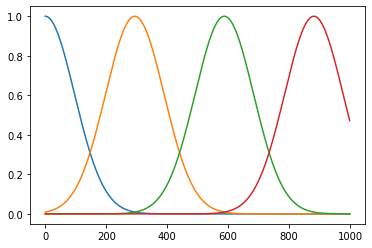

In [37]:
plt.plot([basis_fs[0](x) for x in np.linspace(0, 20, 1000)])
plt.plot([basis_fs[1](x) for x in np.linspace(0, 20, 1000)])
plt.plot([basis_fs[2](x) for x in np.linspace(0, 20, 1000)])
plt.plot([basis_fs[3](x) for x in np.linspace(0, 20, 1000)])
# plt.plot([basis_fs[4](x) for x in range(100)])